## 기본 베이지 DNN

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense,Dropout,Activation
from torch.utils.data import TensorDataset, DataLoader
from tensorflow.python.keras import metrics
from tensorflow.python import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from imblearn.over_sampling import SMOTE
import math
import matplotlib.pyplot as plt
%matplotlib inline



In [2]:
%matplotlib inline

In [3]:
df=pd.read_excel('./optimal_data/'+'Continous_2weeks_28day_8term.xlsx')
df.head()
X=df.iloc[:,[1,3,4,5,6,7]]
y=df.iloc[:,-1]


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
X_scaler = scaler.fit_transform(X)
smote = SMOTE(random_state=0)
X_train_over,y_train_over = smote.fit_resample(X_scaler,y)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_scaler.shape, y.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 전 레이블 값 분포: \n', pd.Series(y).value_counts())
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (2576, 6) (2576,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (5142, 6) (5142,)
SMOTE 적용 전 레이블 값 분포: 
 0    1714
1     512
2     350
Name: 8, dtype: int64
SMOTE 적용 후 레이블 값 분포: 
 0    1714
1    1714
2    1714
Name: 8, dtype: int64


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_train_over, y_train_over, test_size=0.30)

# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)


X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train.to_numpy())
y_test = torch.LongTensor(y_test.to_numpy())

train_dataset = TensorDataset(X_train, y_train)
test_dataset=TensorDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=16,shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=16,shuffle=False)

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [5]:
class DNNModel(nn.Module):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.input_layer = nn.Linear(6, 128)
        self.hidden_layer1 = nn.Linear(128, 256)
        self.hidden_layer2 = nn.Linear(256, 128)
        self.output_layer   = nn.Linear(128,3)
        self.relu = nn.ReLU()



    def forward(self, x):
        out =  self.relu(self.input_layer(x))
        out =  self.relu(self.hidden_layer1(out))
        out =  self.relu(self.hidden_layer2(out))
        out =  self.output_layer(out)
        return out 



# device 설정 (cuda:0 혹은 cpu)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = DNNModel() # Model 생성
model.to(device)   # device 에 로드 (cpu or cuda)

# 옵티마이저를 정의합니다. 옵티마이저에는 model.parameters()를 지정해야 합니다.
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 손실함수(loss function)을 지정합니다. Multi-Class Classification 이기 때문에 CrossEntropy 손실을 지정하였습니다.
loss_fn = nn.CrossEntropyLoss()

In [6]:
from tqdm import tqdm  # Progress Bar 출력

def model_train(model, data_loader, loss_fn, optimizer, device):
    # 모델을 훈련모드로 설정합니다. training mode 일 때 Gradient 가 업데이트 됩니다. 반드시 train()으로 모드 변경을 해야 합니다.
    model.train()
    # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
    running_loss = 0
    corr = 0

    # 예쁘게 Progress Bar를 출력하면서 훈련 상태를 모니터링 하기 위하여 tqdm으로 래핑합니다.
    prograss_bar = tqdm(data_loader)

    # mini-batch 학습을 시작합니다.
    for data, lbl in prograss_bar:
        # image, label 데이터를 device에 올립니다.
        data, lbl = data.to(device), lbl.to(device)
        # 누적 Gradient를 초기화 합니다.
        optimizer.zero_grad()

        # Forward Propagation을 진행하여 결과를 얻습니다.
        output = model(data)

        # 손실함수에 output, label 값을 대입하여 손실을 계산합니다.
        loss = loss_fn(output, lbl)
        # 오차역전파(Back Propagation)을 진행하여 미분 값을 계산합니다.
        loss.backward()

        # 계산된 Gradient를 업데이트 합니다.
        optimizer.step()

        # output의 max(dim=1)은 max probability와 max index를 반환합니다.
        # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
        _, pred = output.max(dim=1)
        # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
        # 합계는 corr 변수에 누적합니다.
        corr += pred.eq(lbl).sum().item()
        
        # loss 값은 1개 배치의 평균 손실(loss) 입니다. data.size(0)은 배치사이즈(batch size) 입니다.
        # loss 와 data.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
        # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
        running_loss += loss.item() * data.size(0)

    # 누적된 정답수를 전체 개수로 나누어 주면 정확도가 산출됩니다.
    acc = corr / len(data_loader.dataset)
    # 평균 손실(loss)과 정확도를 반환합니다.
    # train_loss, train_acc
    return running_loss / len(data_loader.dataset), acc

In [7]:
def model_evaluate(model, data_loader, loss_fn, device):
    # model.eval()은 모델을 평가모드로 설정을 바꾸어 줍니다. 
    # dropout과 같은 layer의 역할 변경을 위하여 evaluation 진행시 꼭 필요한 절차 입니다.
    model.eval()
    # Gradient가 업데이트 되는 것을 방지 하기 위하여 반드시 필요합니다.
    with torch.no_grad():
        # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
        corr = 0
        running_loss = 0

        # 배치별 evaluation을 진행합니다.
        for data, lbl in data_loader:
            # device에 데이터를 올립니다.
            data, lbl = data.to(device), lbl.to(device)

            # 모델에 Forward Propagation을 하여 결과를 도출합니다.
            output = model(data)

            # output의 max(dim=1)은 max probability와 max index를 반환합니다.
            # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
            _, pred = output.max(dim=1)
            

            # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
            # 합계는 corr 변수에 누적합니다.
            corr += torch.sum(pred.eq(lbl)).item()
            
            # loss 값은 1개 배치의 평균 손실(loss) 입니다. data.size(0)은 배치사이즈(batch size) 입니다.
            # loss 와 data.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
            # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
            running_loss += loss_fn(output, lbl).item() * data.size(0)

        # validation 정확도를 계산합니다.
        # 누적한 정답숫자를 전체 데이터셋의 숫자로 나누어 최종 accuracy를 산출합니다.
        acc = corr / len(data_loader.dataset)

        # 결과를 반환합니다.
        # val_loss, val_acc
        return running_loss / len(data_loader.dataset), acc

In [8]:
def model_test(model, data_loader, loss_fn, device):
    # model.eval()은 모델을 평가모드로 설정을 바꾸어 줍니다. 
    # dropout과 같은 layer의 역할 변경을 위하여 evaluation 진행시 꼭 필요한 절차 입니다.
    model.eval()
    pred_list=[]
    # Gradient가 업데이트 되는 것을 방지 하기 위하여 반드시 필요합니다.
    with torch.no_grad():
        # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
        corr = 0
        running_loss = 0

        # 배치별 evaluation을 진행합니다.
        for data, lbl in data_loader:
            # device에 데이터를 올립니다.
            data, lbl = data.to(device), lbl.to(device)

            # 모델에 Forward Propagation을 하여 결과를 도출합니다.
            output = model(data)

            # output의 max(dim=1)은 max probability와 max index를 반환합니다.
            # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
            _, pred = output.max(dim=1)
            pred_array = pred.tolist()
            pred_list.append(pred_array) # confusion matrix를 위해 pred 리턴 값
            # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
            # 합계는 corr 변수에 누적합니다.
            corr += torch.sum(pred.eq(lbl)).item()
            
            # loss 값은 1개 배치의 평균 손실(loss) 입니다. data.size(0)은 배치사이즈(batch size) 입니다.
            # loss 와 data.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
            # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
            running_loss += loss_fn(output, lbl).item() * data.size(0)

        # validation 정확도를 계산합니다.
        # 누적한 정답숫자를 전체 데이터셋의 숫자로 나누어 최종 accuracy를 산출합니다.
        acc = corr / len(data_loader.dataset)

        # 결과를 반환합니다.
        # val_loss, val_acc
        return running_loss / len(data_loader.dataset), acc, pred_list

In [9]:
# 최대 Epoch을 지정합니다.
num_epochs = 500
max_acc = 0
loss_list=[]
acc_list=[]
# Epoch 별 훈련 및 검증을 수행합니다.
for epoch in range(num_epochs):
    # Model Training
    # 훈련 손실과 정확도를 반환 받습니다.
    train_loss, train_acc = model_train(model, train_dataloader, loss_fn, optimizer, device)
    
    # 검증 손실과 검증 정확도를 반환 받습니다.
    val_loss, val_acc = model_evaluate(model, test_dataloader, loss_fn, device)   

    # val_loss 가 개선되었다면 min_loss를 갱신하고 model의 가중치(weights)를 저장합니다.
    if val_acc > max_acc:
        print(f'[INFO] val_acc has been improved from {max_acc:.5f} to {val_acc:.5f}. Saving Model!')
        max_acc = val_acc
        torch.save(model.state_dict(), 'DNNModel.pth')

    # Epoch 별 결과를 출력합니다.
    print(f'epoch {epoch+1:02d}, loss: {train_loss:.5f}, acc: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f}')
    loss_list.append(train_loss)
    acc_list.append(train_acc)
## 저장한 가중치 로드 후 검증 성능 측정

# 모델에 저장한 가중치를 로드합니다.
model.load_state_dict(torch.load('DNNModel.pth'))

# 최종 검증 손실(validation loss)와 검증 정확도(validation accuracy)를 산출합니다.
final_loss, final_acc, pred_list = model_test(model, test_dataloader, loss_fn, device)
print(f'evaluation loss: {final_loss:.5f}, evaluation accuracy: {final_acc:.5f}')


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 616.30it/s]


[INFO] val_acc has been improved from 0.00000 to 0.47764. Saving Model!
epoch 01, loss: 0.96977, acc: 0.50042, val_loss: 0.97867, val_accuracy: 0.47764


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 621.41it/s]


[INFO] val_acc has been improved from 0.47764 to 0.51329. Saving Model!
epoch 02, loss: 0.91565, acc: 0.55321, val_loss: 0.95610, val_accuracy: 0.51329


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 606.33it/s]


[INFO] val_acc has been improved from 0.51329 to 0.52690. Saving Model!
epoch 03, loss: 0.88610, acc: 0.57321, val_loss: 0.93761, val_accuracy: 0.52690


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 598.27it/s]


[INFO] val_acc has been improved from 0.52690 to 0.53662. Saving Model!
epoch 04, loss: 0.85775, acc: 0.59628, val_loss: 0.92112, val_accuracy: 0.53662


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 614.60it/s]


[INFO] val_acc has been improved from 0.53662 to 0.54634. Saving Model!
epoch 05, loss: 0.83035, acc: 0.61211, val_loss: 0.89793, val_accuracy: 0.54634


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 617.99it/s]


[INFO] val_acc has been improved from 0.54634 to 0.55736. Saving Model!
epoch 06, loss: 0.80263, acc: 0.63073, val_loss: 0.87541, val_accuracy: 0.55736


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 623.13it/s]


[INFO] val_acc has been improved from 0.55736 to 0.58069. Saving Model!
epoch 07, loss: 0.77797, acc: 0.64546, val_loss: 0.85828, val_accuracy: 0.58069


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 619.70it/s]


[INFO] val_acc has been improved from 0.58069 to 0.60531. Saving Model!
epoch 08, loss: 0.75622, acc: 0.66380, val_loss: 0.83625, val_accuracy: 0.60531


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 619.82it/s]


[INFO] val_acc has been improved from 0.60531 to 0.61763. Saving Model!
epoch 09, loss: 0.73709, acc: 0.67936, val_loss: 0.83071, val_accuracy: 0.61763


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 631.88it/s]


[INFO] val_acc has been improved from 0.61763 to 0.62800. Saving Model!
epoch 10, loss: 0.72013, acc: 0.68547, val_loss: 0.81893, val_accuracy: 0.62800


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 617.99it/s]


[INFO] val_acc has been improved from 0.62800 to 0.63577. Saving Model!
epoch 11, loss: 0.70567, acc: 0.69519, val_loss: 0.80399, val_accuracy: 0.63577


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 631.88it/s]


[INFO] val_acc has been improved from 0.63577 to 0.64485. Saving Model!
epoch 12, loss: 0.69047, acc: 0.70214, val_loss: 0.79969, val_accuracy: 0.64485


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 623.12it/s]


[INFO] val_acc has been improved from 0.64485 to 0.65781. Saving Model!
epoch 13, loss: 0.67871, acc: 0.70492, val_loss: 0.79201, val_accuracy: 0.65781


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 617.99it/s]


[INFO] val_acc has been improved from 0.65781 to 0.66170. Saving Model!
epoch 14, loss: 0.66661, acc: 0.71214, val_loss: 0.78946, val_accuracy: 0.66170


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 606.33it/s]


epoch 15, loss: 0.65621, acc: 0.71909, val_loss: 0.78076, val_accuracy: 0.65716


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 624.80it/s]


[INFO] val_acc has been improved from 0.66170 to 0.66235. Saving Model!
epoch 16, loss: 0.64636, acc: 0.72215, val_loss: 0.78067, val_accuracy: 0.66235


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 626.60it/s]


[INFO] val_acc has been improved from 0.66235 to 0.66494. Saving Model!
epoch 17, loss: 0.63930, acc: 0.72103, val_loss: 0.77146, val_accuracy: 0.66494


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 614.61it/s]


epoch 18, loss: 0.62864, acc: 0.72631, val_loss: 0.76831, val_accuracy: 0.66105


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 613.17it/s]


[INFO] val_acc has been improved from 0.66494 to 0.66559. Saving Model!
epoch 19, loss: 0.61968, acc: 0.72854, val_loss: 0.76020, val_accuracy: 0.66559


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 614.62it/s]


[INFO] val_acc has been improved from 0.66559 to 0.67984. Saving Model!
epoch 20, loss: 0.61180, acc: 0.73520, val_loss: 0.75264, val_accuracy: 0.67984


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 611.29it/s]


[INFO] val_acc has been improved from 0.67984 to 0.68957. Saving Model!
epoch 21, loss: 0.60424, acc: 0.73826, val_loss: 0.75057, val_accuracy: 0.68957


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 624.86it/s]


epoch 22, loss: 0.59721, acc: 0.74271, val_loss: 0.74359, val_accuracy: 0.68114


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 635.45it/s]


[INFO] val_acc has been improved from 0.68957 to 0.69021. Saving Model!
epoch 23, loss: 0.58947, acc: 0.74493, val_loss: 0.73960, val_accuracy: 0.69021


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 607.97it/s]


epoch 24, loss: 0.58259, acc: 0.74993, val_loss: 0.74477, val_accuracy: 0.68114


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 596.68it/s]


epoch 25, loss: 0.57498, acc: 0.75215, val_loss: 0.73670, val_accuracy: 0.68438


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 614.61it/s]


epoch 26, loss: 0.56955, acc: 0.75521, val_loss: 0.73496, val_accuracy: 0.68049


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 626.60it/s]


[INFO] val_acc has been improved from 0.69021 to 0.69929. Saving Model!
epoch 27, loss: 0.56262, acc: 0.76049, val_loss: 0.72186, val_accuracy: 0.69929


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 617.99it/s]


epoch 28, loss: 0.55722, acc: 0.76049, val_loss: 0.72541, val_accuracy: 0.69475


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 607.97it/s]


epoch 29, loss: 0.55142, acc: 0.76104, val_loss: 0.71996, val_accuracy: 0.69864


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 628.35it/s]


epoch 30, loss: 0.54618, acc: 0.76549, val_loss: 0.72091, val_accuracy: 0.69281


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 604.70it/s]


epoch 31, loss: 0.54106, acc: 0.76521, val_loss: 0.72653, val_accuracy: 0.69540


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 611.28it/s]


epoch 32, loss: 0.53739, acc: 0.76882, val_loss: 0.71936, val_accuracy: 0.69605


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 621.41it/s]


epoch 33, loss: 0.53367, acc: 0.77105, val_loss: 0.72008, val_accuracy: 0.69345


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 612.94it/s]


epoch 34, loss: 0.52892, acc: 0.77133, val_loss: 0.71075, val_accuracy: 0.69410


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 603.08it/s]


[INFO] val_acc has been improved from 0.69929 to 0.69994. Saving Model!
epoch 35, loss: 0.52344, acc: 0.77660, val_loss: 0.71425, val_accuracy: 0.69994


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 617.99it/s]


epoch 36, loss: 0.51837, acc: 0.77549, val_loss: 0.72902, val_accuracy: 0.69799


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 623.13it/s]


epoch 37, loss: 0.51739, acc: 0.77772, val_loss: 0.72465, val_accuracy: 0.69799


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 609.62it/s]


[INFO] val_acc has been improved from 0.69994 to 0.70123. Saving Model!
epoch 38, loss: 0.51017, acc: 0.77744, val_loss: 0.71998, val_accuracy: 0.70123


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 609.62it/s]


epoch 39, loss: 0.50561, acc: 0.78438, val_loss: 0.72038, val_accuracy: 0.69929


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 628.35it/s]


epoch 40, loss: 0.49976, acc: 0.78494, val_loss: 0.71921, val_accuracy: 0.70058


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 621.41it/s]


epoch 41, loss: 0.49827, acc: 0.78355, val_loss: 0.72395, val_accuracy: 0.69994


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 626.60it/s]


[INFO] val_acc has been improved from 0.70123 to 0.70642. Saving Model!
epoch 42, loss: 0.49696, acc: 0.78411, val_loss: 0.71709, val_accuracy: 0.70642


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 624.86it/s]


epoch 43, loss: 0.49142, acc: 0.78522, val_loss: 0.71545, val_accuracy: 0.69994


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 621.41it/s]


[INFO] val_acc has been improved from 0.70642 to 0.71030. Saving Model!
epoch 44, loss: 0.48681, acc: 0.79078, val_loss: 0.71422, val_accuracy: 0.71030


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 604.70it/s]


epoch 45, loss: 0.48183, acc: 0.79383, val_loss: 0.72086, val_accuracy: 0.70901


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 612.94it/s]


[INFO] val_acc has been improved from 0.71030 to 0.71355. Saving Model!
epoch 46, loss: 0.47872, acc: 0.79633, val_loss: 0.70834, val_accuracy: 0.71355


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 606.33it/s]


epoch 47, loss: 0.47493, acc: 0.79605, val_loss: 0.71796, val_accuracy: 0.70901


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 630.11it/s]


epoch 48, loss: 0.47230, acc: 0.79744, val_loss: 0.71541, val_accuracy: 0.71290


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 630.11it/s]


[INFO] val_acc has been improved from 0.71355 to 0.71808. Saving Model!
epoch 49, loss: 0.47088, acc: 0.79355, val_loss: 0.70772, val_accuracy: 0.71808


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 619.69it/s]


[INFO] val_acc has been improved from 0.71808 to 0.71938. Saving Model!
epoch 50, loss: 0.46656, acc: 0.79856, val_loss: 0.70433, val_accuracy: 0.71938


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 630.11it/s]


epoch 51, loss: 0.46337, acc: 0.79800, val_loss: 0.69804, val_accuracy: 0.71873


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 616.30it/s]


epoch 52, loss: 0.46055, acc: 0.80078, val_loss: 0.71446, val_accuracy: 0.71225


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 623.13it/s]


epoch 53, loss: 0.45659, acc: 0.80578, val_loss: 0.70895, val_accuracy: 0.71614


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 621.41it/s]


epoch 54, loss: 0.45451, acc: 0.80439, val_loss: 0.71538, val_accuracy: 0.71873


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 623.13it/s]


[INFO] val_acc has been improved from 0.71938 to 0.72780. Saving Model!
epoch 55, loss: 0.44904, acc: 0.80800, val_loss: 0.69596, val_accuracy: 0.72780


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 617.99it/s]


epoch 56, loss: 0.44860, acc: 0.80884, val_loss: 0.70631, val_accuracy: 0.72456


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 616.30it/s]


epoch 57, loss: 0.44656, acc: 0.81050, val_loss: 0.70119, val_accuracy: 0.72327


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 601.47it/s]


epoch 58, loss: 0.44296, acc: 0.80828, val_loss: 0.71237, val_accuracy: 0.72197


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 642.71it/s]


epoch 59, loss: 0.44192, acc: 0.80772, val_loss: 0.70845, val_accuracy: 0.71873


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 603.08it/s]


epoch 60, loss: 0.43780, acc: 0.81078, val_loss: 0.70289, val_accuracy: 0.72197


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 635.45it/s]


epoch 61, loss: 0.43499, acc: 0.81273, val_loss: 0.71454, val_accuracy: 0.71808


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 611.27it/s]


epoch 62, loss: 0.43426, acc: 0.81078, val_loss: 0.70860, val_accuracy: 0.71808


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 626.60it/s]


epoch 63, loss: 0.43524, acc: 0.80745, val_loss: 0.70693, val_accuracy: 0.71938


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 644.55it/s]


epoch 64, loss: 0.43150, acc: 0.81384, val_loss: 0.70497, val_accuracy: 0.72197


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 623.13it/s]


epoch 65, loss: 0.42761, acc: 0.81189, val_loss: 0.71271, val_accuracy: 0.72262


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 623.13it/s]


epoch 66, loss: 0.42845, acc: 0.80967, val_loss: 0.72306, val_accuracy: 0.72067


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 617.99it/s]


[INFO] val_acc has been improved from 0.72780 to 0.73040. Saving Model!
epoch 67, loss: 0.42833, acc: 0.81161, val_loss: 0.70436, val_accuracy: 0.73040


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 626.60it/s]


[INFO] val_acc has been improved from 0.73040 to 0.73558. Saving Model!
epoch 68, loss: 0.42773, acc: 0.81189, val_loss: 0.70002, val_accuracy: 0.73558


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 633.66it/s]


epoch 69, loss: 0.42246, acc: 0.81634, val_loss: 0.70642, val_accuracy: 0.73234


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 611.27it/s]


epoch 70, loss: 0.42520, acc: 0.81134, val_loss: 0.70910, val_accuracy: 0.73558


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 633.66it/s]


[INFO] val_acc has been improved from 0.73558 to 0.74401. Saving Model!
epoch 71, loss: 0.42095, acc: 0.81745, val_loss: 0.70657, val_accuracy: 0.74401


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 614.62it/s]


epoch 72, loss: 0.42025, acc: 0.81578, val_loss: 0.71555, val_accuracy: 0.74012


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 613.77it/s]


epoch 73, loss: 0.41978, acc: 0.81606, val_loss: 0.70968, val_accuracy: 0.74012


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 606.33it/s]


epoch 74, loss: 0.41647, acc: 0.81801, val_loss: 0.71404, val_accuracy: 0.73688


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 599.87it/s]


epoch 75, loss: 0.41753, acc: 0.81884, val_loss: 0.71920, val_accuracy: 0.73428


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 640.88it/s]


epoch 76, loss: 0.41463, acc: 0.81967, val_loss: 0.73264, val_accuracy: 0.73882


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 637.25it/s]


epoch 77, loss: 0.41165, acc: 0.82523, val_loss: 0.72697, val_accuracy: 0.74401


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 617.99it/s]


epoch 78, loss: 0.41040, acc: 0.82356, val_loss: 0.72677, val_accuracy: 0.74076


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 619.70it/s]


epoch 79, loss: 0.41023, acc: 0.82162, val_loss: 0.73201, val_accuracy: 0.73364


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 593.54it/s]


epoch 80, loss: 0.40941, acc: 0.82301, val_loss: 0.72005, val_accuracy: 0.74206


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 626.60it/s]


[INFO] val_acc has been improved from 0.74401 to 0.74465. Saving Model!
epoch 81, loss: 0.40926, acc: 0.81995, val_loss: 0.72456, val_accuracy: 0.74465


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 633.66it/s]


epoch 82, loss: 0.40665, acc: 0.82745, val_loss: 0.73052, val_accuracy: 0.73882


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 607.97it/s]


epoch 83, loss: 0.40641, acc: 0.82467, val_loss: 0.73094, val_accuracy: 0.73752


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 640.88it/s]


epoch 84, loss: 0.40651, acc: 0.82495, val_loss: 0.73349, val_accuracy: 0.74012


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 616.30it/s]


epoch 85, loss: 0.40879, acc: 0.82384, val_loss: 0.71731, val_accuracy: 0.74336


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 630.11it/s]


[INFO] val_acc has been improved from 0.74465 to 0.74660. Saving Model!
epoch 86, loss: 0.40775, acc: 0.82578, val_loss: 0.74733, val_accuracy: 0.74660


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 593.53it/s]


[INFO] val_acc has been improved from 0.74660 to 0.74789. Saving Model!
epoch 87, loss: 0.40951, acc: 0.82829, val_loss: 0.71759, val_accuracy: 0.74789


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 619.69it/s]


epoch 88, loss: 0.40600, acc: 0.82690, val_loss: 0.71476, val_accuracy: 0.74725


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 616.30it/s]


[INFO] val_acc has been improved from 0.74789 to 0.75308. Saving Model!
epoch 89, loss: 0.40475, acc: 0.82634, val_loss: 0.70438, val_accuracy: 0.75308


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 626.60it/s]


epoch 90, loss: 0.40335, acc: 0.83023, val_loss: 0.70776, val_accuracy: 0.75243


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 611.28it/s]


epoch 91, loss: 0.40265, acc: 0.82995, val_loss: 0.70346, val_accuracy: 0.74789


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 603.08it/s]


[INFO] val_acc has been improved from 0.75308 to 0.75373. Saving Model!
epoch 92, loss: 0.40035, acc: 0.82884, val_loss: 0.69609, val_accuracy: 0.75373


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 633.66it/s]


epoch 93, loss: 0.39496, acc: 0.83412, val_loss: 0.69162, val_accuracy: 0.75113


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 624.86it/s]


[INFO] val_acc has been improved from 0.75373 to 0.75567. Saving Model!
epoch 94, loss: 0.39681, acc: 0.83106, val_loss: 0.70488, val_accuracy: 0.75567


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 621.41it/s]


[INFO] val_acc has been improved from 0.75567 to 0.76021. Saving Model!
epoch 95, loss: 0.39629, acc: 0.82940, val_loss: 0.70915, val_accuracy: 0.76021


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 631.88it/s]


epoch 96, loss: 0.39695, acc: 0.82995, val_loss: 0.70146, val_accuracy: 0.75113


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 639.06it/s]


epoch 97, loss: 0.39220, acc: 0.82940, val_loss: 0.70464, val_accuracy: 0.75697


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 623.13it/s]


[INFO] val_acc has been improved from 0.76021 to 0.76150. Saving Model!
epoch 98, loss: 0.39209, acc: 0.82995, val_loss: 0.68870, val_accuracy: 0.76150


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 630.11it/s]


epoch 99, loss: 0.38570, acc: 0.83190, val_loss: 0.69335, val_accuracy: 0.76150


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 635.45it/s]


[INFO] val_acc has been improved from 0.76150 to 0.76345. Saving Model!
epoch 100, loss: 0.38847, acc: 0.83106, val_loss: 0.69459, val_accuracy: 0.76345


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 623.98it/s]


epoch 101, loss: 0.38969, acc: 0.83106, val_loss: 0.72076, val_accuracy: 0.76280


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 616.30it/s]


epoch 102, loss: 0.38950, acc: 0.83079, val_loss: 0.70456, val_accuracy: 0.76086


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 626.60it/s]


epoch 103, loss: 0.38745, acc: 0.83356, val_loss: 0.69388, val_accuracy: 0.75697


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 616.30it/s]


epoch 104, loss: 0.38705, acc: 0.83523, val_loss: 0.70565, val_accuracy: 0.75762


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 640.88it/s]


epoch 105, loss: 0.39176, acc: 0.83079, val_loss: 0.70012, val_accuracy: 0.74984


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 621.41it/s]


epoch 106, loss: 0.38615, acc: 0.83495, val_loss: 0.70676, val_accuracy: 0.75567


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 607.97it/s]


[INFO] val_acc has been improved from 0.76345 to 0.76604. Saving Model!
epoch 107, loss: 0.38560, acc: 0.83218, val_loss: 0.69224, val_accuracy: 0.76604


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 628.35it/s]


epoch 108, loss: 0.38541, acc: 0.83023, val_loss: 0.69538, val_accuracy: 0.76345


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 624.86it/s]


epoch 109, loss: 0.38125, acc: 0.83190, val_loss: 0.69176, val_accuracy: 0.75502


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 624.86it/s]


epoch 110, loss: 0.38110, acc: 0.83134, val_loss: 0.69944, val_accuracy: 0.75956


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 652.03it/s]


epoch 111, loss: 0.38549, acc: 0.83023, val_loss: 0.69440, val_accuracy: 0.76280


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 612.94it/s]


epoch 112, loss: 0.37925, acc: 0.83579, val_loss: 0.69707, val_accuracy: 0.75762


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 604.70it/s]


epoch 113, loss: 0.37759, acc: 0.83440, val_loss: 0.69319, val_accuracy: 0.75956


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 623.13it/s]


epoch 114, loss: 0.37585, acc: 0.83273, val_loss: 0.69864, val_accuracy: 0.75437


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 623.13it/s]


epoch 115, loss: 0.37447, acc: 0.83106, val_loss: 0.70080, val_accuracy: 0.76215


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 621.41it/s]


epoch 116, loss: 0.37549, acc: 0.83384, val_loss: 0.70594, val_accuracy: 0.76474


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 611.27it/s]


epoch 117, loss: 0.37649, acc: 0.83412, val_loss: 0.70774, val_accuracy: 0.76021


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 623.13it/s]


epoch 118, loss: 0.37293, acc: 0.83384, val_loss: 0.71262, val_accuracy: 0.76215


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 633.66it/s]


epoch 119, loss: 0.37179, acc: 0.83468, val_loss: 0.70637, val_accuracy: 0.76150


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 630.11it/s]


epoch 120, loss: 0.36848, acc: 0.83579, val_loss: 0.71335, val_accuracy: 0.75632


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 624.86it/s]


epoch 121, loss: 0.37014, acc: 0.83718, val_loss: 0.71874, val_accuracy: 0.76021


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 635.45it/s]


epoch 122, loss: 0.36852, acc: 0.83440, val_loss: 0.71885, val_accuracy: 0.75437


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 598.27it/s]


epoch 123, loss: 0.36821, acc: 0.83523, val_loss: 0.72137, val_accuracy: 0.75891


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 631.88it/s]


epoch 124, loss: 0.36621, acc: 0.83634, val_loss: 0.72996, val_accuracy: 0.75891


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 626.60it/s]


epoch 125, loss: 0.36746, acc: 0.83634, val_loss: 0.70916, val_accuracy: 0.76604


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 631.88it/s]


epoch 126, loss: 0.36620, acc: 0.83773, val_loss: 0.71105, val_accuracy: 0.76604


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 619.69it/s]


epoch 127, loss: 0.36637, acc: 0.83884, val_loss: 0.72367, val_accuracy: 0.75502


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 639.06it/s]


epoch 128, loss: 0.36409, acc: 0.84218, val_loss: 0.72112, val_accuracy: 0.76215


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 611.28it/s]


epoch 129, loss: 0.35937, acc: 0.84162, val_loss: 0.71456, val_accuracy: 0.76539


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 640.88it/s]


epoch 130, loss: 0.36078, acc: 0.84357, val_loss: 0.72406, val_accuracy: 0.75632


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 635.45it/s]


epoch 131, loss: 0.36418, acc: 0.83773, val_loss: 0.72975, val_accuracy: 0.76280


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 633.66it/s]


[INFO] val_acc has been improved from 0.76604 to 0.76734. Saving Model!
epoch 132, loss: 0.36133, acc: 0.83801, val_loss: 0.72214, val_accuracy: 0.76734


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 624.86it/s]


epoch 133, loss: 0.35359, acc: 0.84968, val_loss: 0.71061, val_accuracy: 0.76345


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 623.13it/s]


epoch 134, loss: 0.36178, acc: 0.84023, val_loss: 0.73742, val_accuracy: 0.76669


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 639.06it/s]


epoch 135, loss: 0.35667, acc: 0.84273, val_loss: 0.72624, val_accuracy: 0.76280


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 616.30it/s]


epoch 136, loss: 0.35616, acc: 0.84162, val_loss: 0.73242, val_accuracy: 0.76410


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 618.86it/s]


epoch 137, loss: 0.35592, acc: 0.84635, val_loss: 0.73538, val_accuracy: 0.76734


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 633.66it/s]


epoch 138, loss: 0.35807, acc: 0.84690, val_loss: 0.73219, val_accuracy: 0.76474


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 633.66it/s]


[INFO] val_acc has been improved from 0.76734 to 0.77382. Saving Model!
epoch 139, loss: 0.35183, acc: 0.84662, val_loss: 0.72416, val_accuracy: 0.77382


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 626.60it/s]


epoch 140, loss: 0.35397, acc: 0.84440, val_loss: 0.73440, val_accuracy: 0.76086


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 626.60it/s]


epoch 141, loss: 0.35534, acc: 0.84635, val_loss: 0.72288, val_accuracy: 0.76410


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 616.06it/s]


epoch 142, loss: 0.34887, acc: 0.84635, val_loss: 0.72645, val_accuracy: 0.76345


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 618.40it/s]


epoch 143, loss: 0.35114, acc: 0.84551, val_loss: 0.72925, val_accuracy: 0.75891


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 611.27it/s]


epoch 144, loss: 0.35218, acc: 0.84635, val_loss: 0.73008, val_accuracy: 0.75762


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 616.30it/s]


epoch 145, loss: 0.34726, acc: 0.84718, val_loss: 0.74725, val_accuracy: 0.75632


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 623.13it/s]


epoch 146, loss: 0.34908, acc: 0.84662, val_loss: 0.71881, val_accuracy: 0.76798


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 628.35it/s]


epoch 147, loss: 0.34726, acc: 0.84801, val_loss: 0.72738, val_accuracy: 0.76215


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 628.59it/s]


epoch 148, loss: 0.34565, acc: 0.84690, val_loss: 0.72724, val_accuracy: 0.76086


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 604.70it/s]


epoch 149, loss: 0.35083, acc: 0.84940, val_loss: 0.73230, val_accuracy: 0.76669


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 619.69it/s]


epoch 150, loss: 0.34298, acc: 0.84968, val_loss: 0.73856, val_accuracy: 0.75567


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 612.76it/s]


epoch 151, loss: 0.34659, acc: 0.84912, val_loss: 0.74240, val_accuracy: 0.75697


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 623.13it/s]


epoch 152, loss: 0.35452, acc: 0.84523, val_loss: 0.74056, val_accuracy: 0.76280


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 611.28it/s]


epoch 153, loss: 0.34049, acc: 0.85079, val_loss: 0.73741, val_accuracy: 0.76798


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 628.35it/s]


epoch 154, loss: 0.33888, acc: 0.84690, val_loss: 0.75372, val_accuracy: 0.76410


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 637.25it/s]


epoch 155, loss: 0.33772, acc: 0.85218, val_loss: 0.73820, val_accuracy: 0.76604


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 611.27it/s]


epoch 156, loss: 0.33995, acc: 0.85024, val_loss: 0.75639, val_accuracy: 0.76993


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 631.88it/s]


epoch 157, loss: 0.33932, acc: 0.85107, val_loss: 0.72685, val_accuracy: 0.75956


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 611.27it/s]


epoch 158, loss: 0.33590, acc: 0.85301, val_loss: 0.73951, val_accuracy: 0.76280


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 623.11it/s]


epoch 159, loss: 0.33770, acc: 0.85607, val_loss: 0.76965, val_accuracy: 0.75826


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 623.13it/s]


epoch 160, loss: 0.34033, acc: 0.84718, val_loss: 0.77219, val_accuracy: 0.75826


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 626.60it/s]


epoch 161, loss: 0.33501, acc: 0.85107, val_loss: 0.77185, val_accuracy: 0.76150


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 635.45it/s]


epoch 162, loss: 0.33924, acc: 0.84829, val_loss: 0.76953, val_accuracy: 0.76539


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 624.44it/s]


epoch 163, loss: 0.33716, acc: 0.84857, val_loss: 0.74750, val_accuracy: 0.76863


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 635.60it/s]


epoch 164, loss: 0.33046, acc: 0.85135, val_loss: 0.73717, val_accuracy: 0.76863


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 640.88it/s]


epoch 165, loss: 0.33084, acc: 0.85107, val_loss: 0.75930, val_accuracy: 0.76928


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 640.88it/s]


epoch 166, loss: 0.33062, acc: 0.85107, val_loss: 0.75374, val_accuracy: 0.76993


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 630.11it/s]


epoch 167, loss: 0.32955, acc: 0.85468, val_loss: 0.74116, val_accuracy: 0.76345


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 614.62it/s]


epoch 168, loss: 0.33059, acc: 0.85246, val_loss: 0.75667, val_accuracy: 0.77122


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 637.25it/s]


epoch 169, loss: 0.32762, acc: 0.85440, val_loss: 0.75774, val_accuracy: 0.76280


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 627.28it/s]


epoch 170, loss: 0.32715, acc: 0.85746, val_loss: 0.76427, val_accuracy: 0.76150


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 623.13it/s]


epoch 171, loss: 0.32415, acc: 0.85690, val_loss: 0.75714, val_accuracy: 0.76410


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 624.86it/s]


epoch 172, loss: 0.32325, acc: 0.85579, val_loss: 0.75083, val_accuracy: 0.76798


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 624.02it/s]


epoch 173, loss: 0.32214, acc: 0.85718, val_loss: 0.76525, val_accuracy: 0.76604


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 640.88it/s]


epoch 174, loss: 0.32602, acc: 0.85496, val_loss: 0.77265, val_accuracy: 0.76086


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 644.55it/s]


epoch 175, loss: 0.32660, acc: 0.85357, val_loss: 0.76795, val_accuracy: 0.76215


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 611.28it/s]


epoch 176, loss: 0.32319, acc: 0.85440, val_loss: 0.75451, val_accuracy: 0.76086


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 628.35it/s]


epoch 177, loss: 0.32492, acc: 0.85829, val_loss: 0.75526, val_accuracy: 0.76669


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 619.70it/s]


epoch 178, loss: 0.31834, acc: 0.86024, val_loss: 0.77352, val_accuracy: 0.76863


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 621.41it/s]


epoch 179, loss: 0.32834, acc: 0.85941, val_loss: 0.76633, val_accuracy: 0.76604


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 603.21it/s]


epoch 180, loss: 0.32138, acc: 0.85274, val_loss: 0.78255, val_accuracy: 0.76863


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 619.69it/s]


epoch 181, loss: 0.31990, acc: 0.85885, val_loss: 0.78063, val_accuracy: 0.76150


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 635.45it/s]


epoch 182, loss: 0.32436, acc: 0.85885, val_loss: 0.78460, val_accuracy: 0.76215


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 621.41it/s]


epoch 183, loss: 0.32043, acc: 0.85802, val_loss: 0.75208, val_accuracy: 0.76734


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 619.69it/s]


epoch 184, loss: 0.31988, acc: 0.85579, val_loss: 0.76623, val_accuracy: 0.76539


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 637.25it/s]


epoch 185, loss: 0.31643, acc: 0.86218, val_loss: 0.76420, val_accuracy: 0.76539


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 611.27it/s]


[INFO] val_acc has been improved from 0.77382 to 0.77447. Saving Model!
epoch 186, loss: 0.32033, acc: 0.85774, val_loss: 0.75445, val_accuracy: 0.77447


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 623.13it/s]


epoch 187, loss: 0.31426, acc: 0.86052, val_loss: 0.76953, val_accuracy: 0.76539


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 609.62it/s]


epoch 188, loss: 0.32441, acc: 0.85579, val_loss: 0.75769, val_accuracy: 0.76539


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 621.39it/s]


epoch 189, loss: 0.31367, acc: 0.85857, val_loss: 0.77969, val_accuracy: 0.76604


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 626.60it/s]


epoch 190, loss: 0.31911, acc: 0.85718, val_loss: 0.76391, val_accuracy: 0.76993


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 623.13it/s]


epoch 191, loss: 0.31569, acc: 0.86135, val_loss: 0.77279, val_accuracy: 0.76798


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 611.27it/s]


epoch 192, loss: 0.32051, acc: 0.85690, val_loss: 0.79337, val_accuracy: 0.76410


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 619.70it/s]


epoch 193, loss: 0.32065, acc: 0.85802, val_loss: 0.78654, val_accuracy: 0.76345


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 617.99it/s]


epoch 194, loss: 0.32560, acc: 0.85385, val_loss: 0.77286, val_accuracy: 0.76734


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 612.94it/s]


epoch 195, loss: 0.31367, acc: 0.85913, val_loss: 0.77553, val_accuracy: 0.77122


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 628.35it/s]


epoch 196, loss: 0.32336, acc: 0.85496, val_loss: 0.80146, val_accuracy: 0.76604


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 619.68it/s]


epoch 197, loss: 0.31583, acc: 0.85524, val_loss: 0.77547, val_accuracy: 0.77058


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 630.11it/s]


epoch 198, loss: 0.31591, acc: 0.85968, val_loss: 0.80432, val_accuracy: 0.76280


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 611.27it/s]


epoch 199, loss: 0.31729, acc: 0.86246, val_loss: 0.78878, val_accuracy: 0.75762


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 642.69it/s]


epoch 200, loss: 0.31025, acc: 0.85996, val_loss: 0.78487, val_accuracy: 0.76928


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 628.35it/s]


epoch 201, loss: 0.31537, acc: 0.86135, val_loss: 0.78613, val_accuracy: 0.76993


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 628.35it/s]


epoch 202, loss: 0.30705, acc: 0.86079, val_loss: 0.79279, val_accuracy: 0.76928


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 606.33it/s]


epoch 203, loss: 0.31380, acc: 0.85996, val_loss: 0.78500, val_accuracy: 0.77382


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 621.41it/s]


epoch 204, loss: 0.30752, acc: 0.86135, val_loss: 0.79106, val_accuracy: 0.76798


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 614.62it/s]


epoch 205, loss: 0.31781, acc: 0.86357, val_loss: 0.78264, val_accuracy: 0.76669


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 633.66it/s]


epoch 206, loss: 0.30925, acc: 0.86524, val_loss: 0.78857, val_accuracy: 0.76539


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 621.40it/s]


epoch 207, loss: 0.30949, acc: 0.86413, val_loss: 0.77621, val_accuracy: 0.77058


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 614.62it/s]


epoch 208, loss: 0.30754, acc: 0.86163, val_loss: 0.78899, val_accuracy: 0.76734


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 612.94it/s]


epoch 209, loss: 0.30698, acc: 0.86857, val_loss: 0.80360, val_accuracy: 0.76863


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 635.45it/s]


epoch 210, loss: 0.31486, acc: 0.86052, val_loss: 0.77930, val_accuracy: 0.76604


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 623.13it/s]


epoch 211, loss: 0.30533, acc: 0.86552, val_loss: 0.78978, val_accuracy: 0.76539


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 616.30it/s]


epoch 212, loss: 0.30345, acc: 0.86441, val_loss: 0.77864, val_accuracy: 0.76928


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 621.41it/s]


epoch 213, loss: 0.30707, acc: 0.86635, val_loss: 0.80847, val_accuracy: 0.76410


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 612.94it/s]


epoch 214, loss: 0.31163, acc: 0.86468, val_loss: 0.80229, val_accuracy: 0.76150


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 626.60it/s]


epoch 215, loss: 0.30327, acc: 0.86663, val_loss: 0.79402, val_accuracy: 0.76150


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 637.25it/s]


epoch 216, loss: 0.30298, acc: 0.86719, val_loss: 0.78748, val_accuracy: 0.76928


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 609.62it/s]


epoch 217, loss: 0.30188, acc: 0.86802, val_loss: 0.79841, val_accuracy: 0.76863


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 624.86it/s]


epoch 218, loss: 0.30497, acc: 0.86163, val_loss: 0.78674, val_accuracy: 0.77317


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 616.30it/s]


epoch 219, loss: 0.29781, acc: 0.86913, val_loss: 0.80181, val_accuracy: 0.77122


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 626.60it/s]


epoch 220, loss: 0.30417, acc: 0.86607, val_loss: 0.80101, val_accuracy: 0.75826


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 633.66it/s]


epoch 221, loss: 0.30604, acc: 0.86496, val_loss: 0.80127, val_accuracy: 0.76993


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 606.33it/s]


epoch 222, loss: 0.30223, acc: 0.85857, val_loss: 0.81591, val_accuracy: 0.75373


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 628.35it/s]


epoch 223, loss: 0.30874, acc: 0.86107, val_loss: 0.81751, val_accuracy: 0.76410


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 616.28it/s]


epoch 224, loss: 0.30504, acc: 0.86496, val_loss: 0.80964, val_accuracy: 0.76215


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 631.88it/s]


epoch 225, loss: 0.30008, acc: 0.86441, val_loss: 0.80824, val_accuracy: 0.76604


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 628.35it/s]


epoch 226, loss: 0.29936, acc: 0.86802, val_loss: 0.79873, val_accuracy: 0.76539


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 633.01it/s]


epoch 227, loss: 0.29938, acc: 0.86607, val_loss: 0.80379, val_accuracy: 0.75502


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 626.60it/s]


epoch 228, loss: 0.30813, acc: 0.86302, val_loss: 0.80970, val_accuracy: 0.75762


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 628.35it/s]


epoch 229, loss: 0.29719, acc: 0.86802, val_loss: 0.78704, val_accuracy: 0.77058


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 604.70it/s]


epoch 230, loss: 0.30028, acc: 0.86580, val_loss: 0.81545, val_accuracy: 0.76604


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 626.58it/s]


epoch 231, loss: 0.30105, acc: 0.86107, val_loss: 0.79030, val_accuracy: 0.76410


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 628.35it/s]


epoch 232, loss: 0.30100, acc: 0.86663, val_loss: 0.79285, val_accuracy: 0.77187


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 633.66it/s]


epoch 233, loss: 0.29847, acc: 0.86524, val_loss: 0.78768, val_accuracy: 0.76410


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 612.94it/s]


epoch 234, loss: 0.29952, acc: 0.86191, val_loss: 0.80662, val_accuracy: 0.76150


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 629.52it/s]


epoch 235, loss: 0.30277, acc: 0.86441, val_loss: 0.80163, val_accuracy: 0.76734


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 642.71it/s]


epoch 236, loss: 0.30176, acc: 0.86024, val_loss: 0.80896, val_accuracy: 0.76993


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 631.88it/s]


epoch 237, loss: 0.30148, acc: 0.86079, val_loss: 0.81706, val_accuracy: 0.76215


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 621.40it/s]


epoch 238, loss: 0.29410, acc: 0.86635, val_loss: 0.81130, val_accuracy: 0.76474


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 623.13it/s]


epoch 239, loss: 0.29767, acc: 0.86163, val_loss: 0.79601, val_accuracy: 0.77187


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 639.05it/s]


epoch 240, loss: 0.29831, acc: 0.86330, val_loss: 0.81657, val_accuracy: 0.76215


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 624.84it/s]


epoch 241, loss: 0.30275, acc: 0.86774, val_loss: 0.79724, val_accuracy: 0.76604


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 617.99it/s]


epoch 242, loss: 0.30150, acc: 0.86191, val_loss: 0.80237, val_accuracy: 0.76410


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 616.30it/s]


epoch 243, loss: 0.29931, acc: 0.86524, val_loss: 0.79150, val_accuracy: 0.76669


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 628.35it/s]


epoch 244, loss: 0.29934, acc: 0.86441, val_loss: 0.81115, val_accuracy: 0.76539


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 637.23it/s]


epoch 245, loss: 0.29403, acc: 0.86746, val_loss: 0.86970, val_accuracy: 0.75891


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 626.60it/s]


epoch 246, loss: 0.29861, acc: 0.86552, val_loss: 0.80442, val_accuracy: 0.75373


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 637.25it/s]


epoch 247, loss: 0.28887, acc: 0.86913, val_loss: 0.80714, val_accuracy: 0.77252


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 646.41it/s]


epoch 248, loss: 0.28862, acc: 0.86996, val_loss: 0.80470, val_accuracy: 0.76345


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 621.40it/s]


epoch 249, loss: 0.28900, acc: 0.86580, val_loss: 0.80737, val_accuracy: 0.76928


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 623.13it/s]


epoch 250, loss: 0.29011, acc: 0.86830, val_loss: 0.81725, val_accuracy: 0.76280


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 621.41it/s]


epoch 251, loss: 0.29245, acc: 0.86663, val_loss: 0.80596, val_accuracy: 0.76798


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 630.11it/s]


epoch 252, loss: 0.29251, acc: 0.86941, val_loss: 0.81950, val_accuracy: 0.76734


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 617.99it/s]


epoch 253, loss: 0.29911, acc: 0.86496, val_loss: 0.84586, val_accuracy: 0.76150


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 612.94it/s]


epoch 254, loss: 0.30489, acc: 0.86413, val_loss: 0.81573, val_accuracy: 0.77058


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 606.33it/s]


epoch 255, loss: 0.29125, acc: 0.87052, val_loss: 0.78543, val_accuracy: 0.77447


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 631.88it/s]


epoch 256, loss: 0.28546, acc: 0.86996, val_loss: 0.80384, val_accuracy: 0.76734


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 606.33it/s]


epoch 257, loss: 0.28360, acc: 0.87330, val_loss: 0.80149, val_accuracy: 0.76669


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 617.99it/s]


epoch 258, loss: 0.28682, acc: 0.87135, val_loss: 0.81682, val_accuracy: 0.77058


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 616.28it/s]


epoch 259, loss: 0.28323, acc: 0.86913, val_loss: 0.83487, val_accuracy: 0.76474


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 630.11it/s]


epoch 260, loss: 0.29012, acc: 0.86691, val_loss: 0.84085, val_accuracy: 0.76539


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 616.30it/s]


epoch 261, loss: 0.28823, acc: 0.87135, val_loss: 0.82143, val_accuracy: 0.76474


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 628.35it/s]


epoch 262, loss: 0.28484, acc: 0.87163, val_loss: 0.84170, val_accuracy: 0.76669


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 611.27it/s]


epoch 263, loss: 0.29911, acc: 0.86357, val_loss: 0.81224, val_accuracy: 0.77187


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 621.41it/s]


[INFO] val_acc has been improved from 0.77447 to 0.77511. Saving Model!
epoch 264, loss: 0.29440, acc: 0.86524, val_loss: 0.83282, val_accuracy: 0.77511


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 620.00it/s]


epoch 265, loss: 0.28521, acc: 0.87135, val_loss: 0.82120, val_accuracy: 0.76993


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 626.60it/s]


[INFO] val_acc has been improved from 0.77511 to 0.77576. Saving Model!
epoch 266, loss: 0.28300, acc: 0.87219, val_loss: 0.80507, val_accuracy: 0.77576


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 612.94it/s]


epoch 267, loss: 0.27981, acc: 0.87219, val_loss: 0.84525, val_accuracy: 0.76928


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 624.86it/s]


epoch 268, loss: 0.29398, acc: 0.87080, val_loss: 0.81749, val_accuracy: 0.77576


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 604.25it/s]


epoch 269, loss: 0.28945, acc: 0.86802, val_loss: 0.82797, val_accuracy: 0.77187


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 601.47it/s]


epoch 270, loss: 0.28293, acc: 0.87246, val_loss: 0.79550, val_accuracy: 0.77187


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 628.35it/s]


epoch 271, loss: 0.28070, acc: 0.87080, val_loss: 0.81061, val_accuracy: 0.77511


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 616.28it/s]


epoch 272, loss: 0.28252, acc: 0.87052, val_loss: 0.82637, val_accuracy: 0.77252


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 628.35it/s]


epoch 273, loss: 0.28649, acc: 0.86885, val_loss: 0.82750, val_accuracy: 0.77317


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 628.35it/s]


[INFO] val_acc has been improved from 0.77576 to 0.77900. Saving Model!
epoch 274, loss: 0.28212, acc: 0.87219, val_loss: 0.82673, val_accuracy: 0.77900


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 617.99it/s]


epoch 275, loss: 0.28115, acc: 0.87330, val_loss: 0.81056, val_accuracy: 0.77252


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 617.99it/s]


epoch 276, loss: 0.28661, acc: 0.86857, val_loss: 0.81080, val_accuracy: 0.77382


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 629.73it/s]


epoch 277, loss: 0.28579, acc: 0.87274, val_loss: 0.84045, val_accuracy: 0.76734


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 609.62it/s]


epoch 278, loss: 0.28278, acc: 0.87108, val_loss: 0.81072, val_accuracy: 0.76798


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 617.99it/s]


epoch 279, loss: 0.28140, acc: 0.87302, val_loss: 0.82528, val_accuracy: 0.77187


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 614.62it/s]


epoch 280, loss: 0.28738, acc: 0.87108, val_loss: 0.81996, val_accuracy: 0.76669


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 623.13it/s]


epoch 281, loss: 0.28727, acc: 0.86996, val_loss: 0.82350, val_accuracy: 0.76993


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 619.70it/s]


epoch 282, loss: 0.29603, acc: 0.86885, val_loss: 0.81326, val_accuracy: 0.77382


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 611.27it/s]


epoch 283, loss: 0.28613, acc: 0.87441, val_loss: 0.82967, val_accuracy: 0.77252


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 596.68it/s]


epoch 284, loss: 0.28037, acc: 0.87219, val_loss: 0.82265, val_accuracy: 0.76928


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 604.70it/s]


epoch 285, loss: 0.28601, acc: 0.86941, val_loss: 0.83862, val_accuracy: 0.76798


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 601.47it/s]


[INFO] val_acc has been improved from 0.77900 to 0.78419. Saving Model!
epoch 286, loss: 0.27946, acc: 0.86996, val_loss: 0.82245, val_accuracy: 0.78419


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 607.97it/s]


epoch 287, loss: 0.27647, acc: 0.87024, val_loss: 0.82336, val_accuracy: 0.77511


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 599.86it/s]


epoch 288, loss: 0.28153, acc: 0.86857, val_loss: 0.81148, val_accuracy: 0.77317


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 612.93it/s]


epoch 289, loss: 0.27935, acc: 0.87080, val_loss: 0.83286, val_accuracy: 0.77382


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 616.30it/s]


epoch 290, loss: 0.28336, acc: 0.87135, val_loss: 0.82921, val_accuracy: 0.77187


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 612.94it/s]


epoch 291, loss: 0.28232, acc: 0.87246, val_loss: 0.84859, val_accuracy: 0.77122


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 604.70it/s]


epoch 292, loss: 0.28158, acc: 0.86774, val_loss: 0.83389, val_accuracy: 0.77576


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 616.30it/s]


epoch 293, loss: 0.27829, acc: 0.87135, val_loss: 0.83678, val_accuracy: 0.77317


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 619.69it/s]


epoch 294, loss: 0.28728, acc: 0.86913, val_loss: 0.84073, val_accuracy: 0.77835


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 596.68it/s]


epoch 295, loss: 0.28458, acc: 0.87052, val_loss: 0.82607, val_accuracy: 0.77382


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 603.08it/s]


epoch 296, loss: 0.28309, acc: 0.86857, val_loss: 0.84233, val_accuracy: 0.76863


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 611.28it/s]


epoch 297, loss: 0.29034, acc: 0.87080, val_loss: 0.82383, val_accuracy: 0.78224


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 599.86it/s]


epoch 298, loss: 0.28119, acc: 0.86802, val_loss: 0.83024, val_accuracy: 0.77835


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 587.33it/s]


epoch 299, loss: 0.27448, acc: 0.87385, val_loss: 0.83110, val_accuracy: 0.78030


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 598.27it/s]


epoch 300, loss: 0.27170, acc: 0.87663, val_loss: 0.82932, val_accuracy: 0.77900


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 617.99it/s]


epoch 301, loss: 0.27066, acc: 0.87802, val_loss: 0.84039, val_accuracy: 0.78289


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 601.39it/s]


[INFO] val_acc has been improved from 0.78419 to 0.78613. Saving Model!
epoch 302, loss: 0.27214, acc: 0.87608, val_loss: 0.83275, val_accuracy: 0.78613


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 595.10it/s]


[INFO] val_acc has been improved from 0.78613 to 0.78743. Saving Model!
epoch 303, loss: 0.27593, acc: 0.87719, val_loss: 0.83451, val_accuracy: 0.78743


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 593.53it/s]


epoch 304, loss: 0.27570, acc: 0.87858, val_loss: 0.82662, val_accuracy: 0.78678


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 598.27it/s]


epoch 305, loss: 0.28510, acc: 0.87358, val_loss: 0.85481, val_accuracy: 0.77835


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 611.27it/s]


epoch 306, loss: 0.27138, acc: 0.87747, val_loss: 0.85351, val_accuracy: 0.77965


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 596.68it/s]


epoch 307, loss: 0.27696, acc: 0.87413, val_loss: 0.86339, val_accuracy: 0.78613


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 603.08it/s]


epoch 308, loss: 0.26632, acc: 0.87913, val_loss: 0.85136, val_accuracy: 0.78419


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 611.26it/s]


epoch 309, loss: 0.27350, acc: 0.88024, val_loss: 0.86229, val_accuracy: 0.78419


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 601.47it/s]


[INFO] val_acc has been improved from 0.78743 to 0.78808. Saving Model!
epoch 310, loss: 0.27325, acc: 0.87969, val_loss: 0.86935, val_accuracy: 0.78808


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 599.86it/s]


epoch 311, loss: 0.27276, acc: 0.87719, val_loss: 0.86141, val_accuracy: 0.78159


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 593.53it/s]


epoch 312, loss: 0.26585, acc: 0.87969, val_loss: 0.86513, val_accuracy: 0.77965


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 585.79it/s]


epoch 313, loss: 0.27269, acc: 0.87858, val_loss: 0.87120, val_accuracy: 0.77447


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 582.77it/s]


epoch 314, loss: 0.27774, acc: 0.87441, val_loss: 0.88718, val_accuracy: 0.77382


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 591.97it/s]


epoch 315, loss: 0.27868, acc: 0.87469, val_loss: 0.91241, val_accuracy: 0.77187


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 594.38it/s]


epoch 316, loss: 0.27364, acc: 0.87552, val_loss: 0.86907, val_accuracy: 0.77576


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 593.54it/s]


epoch 317, loss: 0.27607, acc: 0.87358, val_loss: 0.87949, val_accuracy: 0.77576


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 599.86it/s]


epoch 318, loss: 0.26665, acc: 0.87524, val_loss: 0.85442, val_accuracy: 0.78289


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 585.80it/s]


[INFO] val_acc has been improved from 0.78808 to 0.79067. Saving Model!
epoch 319, loss: 0.26969, acc: 0.87663, val_loss: 0.86547, val_accuracy: 0.79067


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 584.28it/s]


epoch 320, loss: 0.27058, acc: 0.87385, val_loss: 0.86088, val_accuracy: 0.78808


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 595.10it/s]


epoch 321, loss: 0.26616, acc: 0.87719, val_loss: 0.87181, val_accuracy: 0.77900


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 590.41it/s]


epoch 322, loss: 0.26635, acc: 0.88080, val_loss: 0.85939, val_accuracy: 0.78613


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 601.47it/s]


epoch 323, loss: 0.26833, acc: 0.87802, val_loss: 0.88887, val_accuracy: 0.77835


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 590.42it/s]


epoch 324, loss: 0.27049, acc: 0.87941, val_loss: 0.86863, val_accuracy: 0.78354


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 584.28it/s]


epoch 325, loss: 0.27272, acc: 0.87469, val_loss: 0.88587, val_accuracy: 0.78159


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 601.47it/s]


epoch 326, loss: 0.29129, acc: 0.87219, val_loss: 0.86879, val_accuracy: 0.78224


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 591.97it/s]


epoch 327, loss: 0.27107, acc: 0.87413, val_loss: 0.88890, val_accuracy: 0.78289


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 590.42it/s]


epoch 328, loss: 0.27165, acc: 0.87886, val_loss: 0.86832, val_accuracy: 0.77511


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 587.34it/s]


epoch 329, loss: 0.26752, acc: 0.88024, val_loss: 0.89014, val_accuracy: 0.78289


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 591.97it/s]


epoch 330, loss: 0.26501, acc: 0.88191, val_loss: 0.87699, val_accuracy: 0.77447


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 596.68it/s]


epoch 331, loss: 0.26585, acc: 0.87719, val_loss: 0.89593, val_accuracy: 0.77641


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 591.97it/s]


epoch 332, loss: 0.26380, acc: 0.88163, val_loss: 0.91704, val_accuracy: 0.77511


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 585.80it/s]


epoch 333, loss: 0.27023, acc: 0.88052, val_loss: 0.87184, val_accuracy: 0.77965


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 575.32it/s]


epoch 334, loss: 0.26056, acc: 0.88302, val_loss: 0.86766, val_accuracy: 0.78030


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 587.33it/s]


epoch 335, loss: 0.26180, acc: 0.88163, val_loss: 0.87041, val_accuracy: 0.78743


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 573.85it/s]


epoch 336, loss: 0.26413, acc: 0.87941, val_loss: 0.90994, val_accuracy: 0.76798


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 575.32it/s]


epoch 337, loss: 0.26910, acc: 0.87747, val_loss: 0.86321, val_accuracy: 0.78678


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 587.33it/s]


epoch 338, loss: 0.26962, acc: 0.87497, val_loss: 0.87170, val_accuracy: 0.78548


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 573.85it/s]


epoch 339, loss: 0.26697, acc: 0.87830, val_loss: 0.88753, val_accuracy: 0.77835


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 601.47it/s]


epoch 340, loss: 0.27192, acc: 0.87830, val_loss: 0.93213, val_accuracy: 0.77058


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 588.87it/s]


epoch 341, loss: 0.27325, acc: 0.87802, val_loss: 0.90890, val_accuracy: 0.77576


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 591.97it/s]


epoch 342, loss: 0.27139, acc: 0.87719, val_loss: 0.88031, val_accuracy: 0.77447


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 575.32it/s]


epoch 343, loss: 0.26254, acc: 0.88080, val_loss: 0.93609, val_accuracy: 0.77576


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 566.62it/s]


epoch 344, loss: 0.26391, acc: 0.88136, val_loss: 0.88004, val_accuracy: 0.78354


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 581.26it/s]


epoch 345, loss: 0.25838, acc: 0.87941, val_loss: 0.87567, val_accuracy: 0.78289


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 575.32it/s]


epoch 346, loss: 0.26103, acc: 0.88163, val_loss: 0.88278, val_accuracy: 0.78224


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 579.77it/s]


epoch 347, loss: 0.26661, acc: 0.88191, val_loss: 0.90584, val_accuracy: 0.77771


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 572.37it/s]


epoch 348, loss: 0.26118, acc: 0.88052, val_loss: 0.86616, val_accuracy: 0.77706


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 588.87it/s]


epoch 349, loss: 0.27222, acc: 0.87691, val_loss: 0.89523, val_accuracy: 0.77382


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 595.08it/s]


epoch 350, loss: 0.26281, acc: 0.87524, val_loss: 0.88525, val_accuracy: 0.78613


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 575.32it/s]


epoch 351, loss: 0.25644, acc: 0.88219, val_loss: 0.90664, val_accuracy: 0.77382


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 599.86it/s]


epoch 352, loss: 0.25576, acc: 0.88275, val_loss: 0.89407, val_accuracy: 0.78289


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 590.42it/s]


epoch 353, loss: 0.25811, acc: 0.88191, val_loss: 0.87826, val_accuracy: 0.78743


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 581.26it/s]


epoch 354, loss: 0.26213, acc: 0.87719, val_loss: 0.89229, val_accuracy: 0.77900


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 582.77it/s]


epoch 355, loss: 0.25913, acc: 0.88441, val_loss: 0.91352, val_accuracy: 0.77900


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 559.58it/s]


epoch 356, loss: 0.25835, acc: 0.88413, val_loss: 0.89887, val_accuracy: 0.78483


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 568.05it/s]


epoch 357, loss: 0.25968, acc: 0.88330, val_loss: 0.87272, val_accuracy: 0.78419


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 563.77it/s]


epoch 358, loss: 0.25815, acc: 0.88219, val_loss: 0.89852, val_accuracy: 0.77576


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 573.85it/s]


epoch 359, loss: 0.26414, acc: 0.88080, val_loss: 0.90459, val_accuracy: 0.77576


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 572.39it/s]


epoch 360, loss: 0.25957, acc: 0.88163, val_loss: 0.91383, val_accuracy: 0.77706


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 570.94it/s]


epoch 361, loss: 0.26748, acc: 0.87608, val_loss: 0.89764, val_accuracy: 0.77706


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 558.19it/s]


epoch 362, loss: 0.26678, acc: 0.88136, val_loss: 0.90067, val_accuracy: 0.77771


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 564.48it/s]


epoch 363, loss: 0.26207, acc: 0.88358, val_loss: 0.90774, val_accuracy: 0.77706


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 581.26it/s]


epoch 364, loss: 0.25792, acc: 0.88580, val_loss: 0.91886, val_accuracy: 0.77511


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 572.39it/s]


epoch 365, loss: 0.26148, acc: 0.88136, val_loss: 0.90226, val_accuracy: 0.77317


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 576.79it/s]


epoch 366, loss: 0.25738, acc: 0.88080, val_loss: 0.89387, val_accuracy: 0.77900


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 593.53it/s]


epoch 367, loss: 0.25819, acc: 0.88358, val_loss: 0.90420, val_accuracy: 0.77641


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 576.79it/s]


epoch 368, loss: 0.27390, acc: 0.87802, val_loss: 0.90340, val_accuracy: 0.78678


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 575.32it/s]


epoch 369, loss: 0.25944, acc: 0.88525, val_loss: 0.91120, val_accuracy: 0.78224


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 576.78it/s]


epoch 370, loss: 0.25378, acc: 0.88330, val_loss: 0.90836, val_accuracy: 0.77576


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 601.47it/s]


epoch 371, loss: 0.25652, acc: 0.88525, val_loss: 0.92013, val_accuracy: 0.78483


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 576.79it/s]


epoch 372, loss: 0.25205, acc: 0.88858, val_loss: 0.90048, val_accuracy: 0.78354


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 575.32it/s]


epoch 373, loss: 0.25634, acc: 0.88469, val_loss: 0.88031, val_accuracy: 0.78095


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 573.84it/s]


epoch 374, loss: 0.25135, acc: 0.88719, val_loss: 0.89951, val_accuracy: 0.77252


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 584.28it/s]


epoch 375, loss: 0.25661, acc: 0.88330, val_loss: 0.89302, val_accuracy: 0.78159


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 569.49it/s]


epoch 376, loss: 0.25081, acc: 0.88247, val_loss: 0.90494, val_accuracy: 0.78224


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 564.63it/s]


epoch 377, loss: 0.24903, acc: 0.88802, val_loss: 0.89097, val_accuracy: 0.77706


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 581.26it/s]


epoch 378, loss: 0.25264, acc: 0.87858, val_loss: 0.88723, val_accuracy: 0.77706


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 584.28it/s]


epoch 379, loss: 0.25550, acc: 0.88219, val_loss: 0.88674, val_accuracy: 0.77771


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 570.94it/s]


epoch 380, loss: 0.26124, acc: 0.88080, val_loss: 0.89567, val_accuracy: 0.78095


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 578.28it/s]


epoch 381, loss: 0.25210, acc: 0.88302, val_loss: 0.90402, val_accuracy: 0.78483


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 576.79it/s]


epoch 382, loss: 0.25485, acc: 0.88525, val_loss: 0.93585, val_accuracy: 0.77382


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 548.64it/s]


epoch 383, loss: 0.25096, acc: 0.88580, val_loss: 0.93524, val_accuracy: 0.77317


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 569.49it/s]


epoch 384, loss: 0.25389, acc: 0.88552, val_loss: 0.93892, val_accuracy: 0.77447


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 574.62it/s]


epoch 385, loss: 0.25846, acc: 0.88191, val_loss: 0.93356, val_accuracy: 0.77835


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 582.77it/s]


epoch 386, loss: 0.25556, acc: 0.88497, val_loss: 0.92027, val_accuracy: 0.78095


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 573.85it/s]


epoch 387, loss: 0.25022, acc: 0.88691, val_loss: 0.97826, val_accuracy: 0.77252


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 562.40it/s]


epoch 388, loss: 0.25175, acc: 0.88358, val_loss: 0.93380, val_accuracy: 0.78354


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 581.26it/s]


epoch 389, loss: 0.25187, acc: 0.88747, val_loss: 0.92976, val_accuracy: 0.77447


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 573.85it/s]


epoch 390, loss: 0.26119, acc: 0.88163, val_loss: 0.92699, val_accuracy: 0.77771


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 572.39it/s]


epoch 391, loss: 0.26011, acc: 0.88191, val_loss: 0.94570, val_accuracy: 0.77771


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 551.35it/s]


epoch 392, loss: 0.24480, acc: 0.89053, val_loss: 0.91787, val_accuracy: 0.78613


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 591.96it/s]


epoch 393, loss: 0.25551, acc: 0.88691, val_loss: 0.93249, val_accuracy: 0.77965


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 569.49it/s]


epoch 394, loss: 0.25928, acc: 0.88052, val_loss: 0.91239, val_accuracy: 0.78613


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 581.26it/s]


epoch 395, loss: 0.24860, acc: 0.88747, val_loss: 0.91206, val_accuracy: 0.78224


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 588.87it/s]


epoch 396, loss: 0.24792, acc: 0.88636, val_loss: 0.89440, val_accuracy: 0.77706


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 571.80it/s]


epoch 397, loss: 0.24348, acc: 0.88941, val_loss: 0.89169, val_accuracy: 0.78030


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 578.28it/s]


epoch 398, loss: 0.25074, acc: 0.88580, val_loss: 0.90367, val_accuracy: 0.78354


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 573.85it/s]


epoch 399, loss: 0.24581, acc: 0.88636, val_loss: 0.94893, val_accuracy: 0.77641


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 579.77it/s]


epoch 400, loss: 0.24452, acc: 0.88914, val_loss: 0.92893, val_accuracy: 0.77252


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 585.81it/s]


epoch 401, loss: 0.24995, acc: 0.88775, val_loss: 0.92667, val_accuracy: 0.78289


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 572.37it/s]


epoch 402, loss: 0.24415, acc: 0.88747, val_loss: 0.92775, val_accuracy: 0.77900


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 575.32it/s]


epoch 403, loss: 0.24948, acc: 0.88358, val_loss: 0.91178, val_accuracy: 0.77187


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 575.32it/s]


epoch 404, loss: 0.24767, acc: 0.88886, val_loss: 0.91120, val_accuracy: 0.78354


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 578.28it/s]


epoch 405, loss: 0.24611, acc: 0.88775, val_loss: 0.92003, val_accuracy: 0.78095


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 570.94it/s]


epoch 406, loss: 0.24159, acc: 0.88719, val_loss: 0.97019, val_accuracy: 0.77447


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 579.77it/s]


epoch 407, loss: 0.25461, acc: 0.88191, val_loss: 0.94816, val_accuracy: 0.77641


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 562.37it/s]


epoch 408, loss: 0.26037, acc: 0.87997, val_loss: 0.92847, val_accuracy: 0.78872


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 573.21it/s]


epoch 409, loss: 0.26313, acc: 0.88747, val_loss: 0.89209, val_accuracy: 0.78613


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 562.37it/s]


epoch 410, loss: 0.24632, acc: 0.88775, val_loss: 0.90709, val_accuracy: 0.77706


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 576.79it/s]


epoch 411, loss: 0.24118, acc: 0.89247, val_loss: 0.91309, val_accuracy: 0.77965


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 588.87it/s]


epoch 412, loss: 0.24730, acc: 0.88636, val_loss: 0.94195, val_accuracy: 0.77835


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 573.85it/s]


epoch 413, loss: 0.24899, acc: 0.88997, val_loss: 0.93929, val_accuracy: 0.77706


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 572.39it/s]


epoch 414, loss: 0.24518, acc: 0.88469, val_loss: 0.94884, val_accuracy: 0.77771


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 585.80it/s]


epoch 415, loss: 0.24436, acc: 0.88941, val_loss: 0.92459, val_accuracy: 0.77641


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 582.77it/s]


epoch 416, loss: 0.24033, acc: 0.89108, val_loss: 0.93272, val_accuracy: 0.77965


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 588.87it/s]


epoch 417, loss: 0.24840, acc: 0.88775, val_loss: 0.95756, val_accuracy: 0.77122


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 576.79it/s]


epoch 418, loss: 0.24442, acc: 0.88858, val_loss: 0.96118, val_accuracy: 0.77900


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 569.49it/s]


epoch 419, loss: 0.24208, acc: 0.88969, val_loss: 0.92321, val_accuracy: 0.78224


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 569.49it/s]


epoch 420, loss: 0.24767, acc: 0.88802, val_loss: 0.93680, val_accuracy: 0.78159


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 574.10it/s]


epoch 421, loss: 0.25270, acc: 0.88664, val_loss: 0.93346, val_accuracy: 0.78159


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 579.77it/s]


epoch 422, loss: 0.24053, acc: 0.89053, val_loss: 0.93247, val_accuracy: 0.78743


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 565.20it/s]


epoch 423, loss: 0.23951, acc: 0.89108, val_loss: 0.91869, val_accuracy: 0.77900


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 568.05it/s]


epoch 424, loss: 0.24167, acc: 0.89025, val_loss: 0.94187, val_accuracy: 0.78095


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 575.32it/s]


epoch 425, loss: 0.24567, acc: 0.89164, val_loss: 0.95501, val_accuracy: 0.77835


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 575.30it/s]


epoch 426, loss: 0.25184, acc: 0.88580, val_loss: 0.94696, val_accuracy: 0.77576


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 566.62it/s]


epoch 427, loss: 0.25192, acc: 0.88552, val_loss: 0.93663, val_accuracy: 0.78095


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 546.06it/s]


epoch 428, loss: 0.25099, acc: 0.88580, val_loss: 0.95182, val_accuracy: 0.78159


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 556.80it/s]


epoch 429, loss: 0.23829, acc: 0.88997, val_loss: 0.94387, val_accuracy: 0.77900


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 535.59it/s]


epoch 430, loss: 0.24158, acc: 0.88858, val_loss: 0.92470, val_accuracy: 0.79067


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 568.05it/s]


epoch 431, loss: 0.24394, acc: 0.88719, val_loss: 0.93485, val_accuracy: 0.77900


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 572.17it/s]


epoch 432, loss: 0.24840, acc: 0.88497, val_loss: 0.94320, val_accuracy: 0.77187


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 535.59it/s]


epoch 433, loss: 0.25238, acc: 0.88775, val_loss: 0.92603, val_accuracy: 0.78095


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 562.37it/s]


epoch 434, loss: 0.24187, acc: 0.88858, val_loss: 0.92996, val_accuracy: 0.77382


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 569.49it/s]


epoch 435, loss: 0.23843, acc: 0.89025, val_loss: 0.94286, val_accuracy: 0.77576


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 562.37it/s]


epoch 436, loss: 0.24523, acc: 0.88469, val_loss: 0.93811, val_accuracy: 0.77576


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 538.15it/s]


epoch 437, loss: 0.24040, acc: 0.89247, val_loss: 0.98146, val_accuracy: 0.78095


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 563.78it/s]


epoch 438, loss: 0.24340, acc: 0.88858, val_loss: 0.93754, val_accuracy: 0.77706


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 558.19it/s]


epoch 439, loss: 0.24661, acc: 0.89025, val_loss: 0.93978, val_accuracy: 0.77965


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 552.70it/s]


epoch 440, loss: 0.24557, acc: 0.89191, val_loss: 0.94360, val_accuracy: 0.77965


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 584.28it/s]


epoch 441, loss: 0.25424, acc: 0.88719, val_loss: 0.91641, val_accuracy: 0.78030


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 542.05it/s]


epoch 442, loss: 0.23697, acc: 0.89247, val_loss: 0.96167, val_accuracy: 0.78419


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 546.08it/s]


epoch 443, loss: 0.23696, acc: 0.89469, val_loss: 0.95404, val_accuracy: 0.78224


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 565.20it/s]


epoch 444, loss: 0.24016, acc: 0.89247, val_loss: 0.92874, val_accuracy: 0.78937


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 554.06it/s]


epoch 445, loss: 0.23985, acc: 0.88802, val_loss: 0.93828, val_accuracy: 0.77900


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 584.28it/s]


epoch 446, loss: 0.22775, acc: 0.89747, val_loss: 0.92724, val_accuracy: 0.79002


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 575.32it/s]


epoch 447, loss: 0.23515, acc: 0.89164, val_loss: 0.92683, val_accuracy: 0.78354


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 569.49it/s]


epoch 448, loss: 0.23713, acc: 0.88941, val_loss: 0.92036, val_accuracy: 0.79002


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 568.05it/s]


epoch 449, loss: 0.23225, acc: 0.89219, val_loss: 0.94550, val_accuracy: 0.78289


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 555.41it/s]


epoch 450, loss: 0.23344, acc: 0.89053, val_loss: 0.92818, val_accuracy: 0.78419


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 555.43it/s]


epoch 451, loss: 0.24650, acc: 0.89080, val_loss: 0.98484, val_accuracy: 0.78095


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 562.36it/s]


epoch 452, loss: 0.24582, acc: 0.88941, val_loss: 0.95856, val_accuracy: 0.77900


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 563.78it/s]


epoch 453, loss: 0.24373, acc: 0.89303, val_loss: 0.97350, val_accuracy: 0.77317


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 573.85it/s]


epoch 454, loss: 0.24275, acc: 0.88830, val_loss: 0.93466, val_accuracy: 0.78159


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 560.28it/s]


epoch 455, loss: 0.23243, acc: 0.89747, val_loss: 0.96432, val_accuracy: 0.78095


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 560.97it/s]


epoch 456, loss: 0.23149, acc: 0.89580, val_loss: 0.96821, val_accuracy: 0.77382


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 568.06it/s]


epoch 457, loss: 0.23349, acc: 0.89414, val_loss: 0.95014, val_accuracy: 0.78224


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 562.37it/s]


epoch 458, loss: 0.23177, acc: 0.89136, val_loss: 0.95465, val_accuracy: 0.78548


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 551.32it/s]


epoch 459, loss: 0.22867, acc: 0.89608, val_loss: 0.95993, val_accuracy: 0.78678


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 547.32it/s]


epoch 460, loss: 0.23493, acc: 0.89386, val_loss: 0.97977, val_accuracy: 0.78224


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 569.49it/s]


epoch 461, loss: 0.24747, acc: 0.88608, val_loss: 0.97560, val_accuracy: 0.76993


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 579.76it/s]


epoch 462, loss: 0.24000, acc: 0.88997, val_loss: 0.96462, val_accuracy: 0.77641


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 581.26it/s]


epoch 463, loss: 0.24980, acc: 0.88719, val_loss: 0.96045, val_accuracy: 0.78743


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 563.78it/s]


epoch 464, loss: 0.24549, acc: 0.89025, val_loss: 0.96040, val_accuracy: 0.78289


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 566.62it/s]


epoch 465, loss: 0.23922, acc: 0.89164, val_loss: 0.97536, val_accuracy: 0.77576


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 555.41it/s]


epoch 466, loss: 0.24361, acc: 0.89080, val_loss: 0.94842, val_accuracy: 0.77706


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 544.67it/s]


epoch 467, loss: 0.22811, acc: 0.89358, val_loss: 0.95715, val_accuracy: 0.77641


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 549.73it/s]


epoch 468, loss: 0.22787, acc: 0.89164, val_loss: 0.98649, val_accuracy: 0.78743


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 542.05it/s]


epoch 469, loss: 0.23469, acc: 0.89330, val_loss: 1.00309, val_accuracy: 0.78289


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 545.99it/s]


epoch 470, loss: 0.23261, acc: 0.89136, val_loss: 0.95851, val_accuracy: 0.78548


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 530.67it/s]


epoch 471, loss: 0.22758, acc: 0.89108, val_loss: 0.95612, val_accuracy: 0.78159


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 561.70it/s]


epoch 472, loss: 0.23060, acc: 0.89358, val_loss: 0.94043, val_accuracy: 0.78678


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 550.00it/s]


epoch 473, loss: 0.23810, acc: 0.89219, val_loss: 0.95941, val_accuracy: 0.77252


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 559.31it/s]


epoch 474, loss: 0.23730, acc: 0.89025, val_loss: 0.94832, val_accuracy: 0.77511


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 566.62it/s]


epoch 475, loss: 0.23334, acc: 0.89247, val_loss: 0.94404, val_accuracy: 0.79002


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 559.57it/s]


epoch 476, loss: 0.22927, acc: 0.89219, val_loss: 0.95401, val_accuracy: 0.78678


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 563.78it/s]


epoch 477, loss: 0.24293, acc: 0.89303, val_loss: 0.96858, val_accuracy: 0.77965


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 548.64it/s]


epoch 478, loss: 0.23156, acc: 0.89386, val_loss: 0.98705, val_accuracy: 0.77576


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 551.35it/s]


epoch 479, loss: 0.23387, acc: 0.89358, val_loss: 0.97253, val_accuracy: 0.78548


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 554.06it/s]


epoch 480, loss: 0.23539, acc: 0.89080, val_loss: 0.96119, val_accuracy: 0.78354


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 550.00it/s]


epoch 481, loss: 0.23082, acc: 0.89358, val_loss: 1.00124, val_accuracy: 0.77641


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 554.06it/s]


epoch 482, loss: 0.23138, acc: 0.89386, val_loss: 0.95662, val_accuracy: 0.79067


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 559.57it/s]


epoch 483, loss: 0.23246, acc: 0.89358, val_loss: 0.99520, val_accuracy: 0.76798


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 587.33it/s]


epoch 484, loss: 0.24266, acc: 0.88469, val_loss: 0.95734, val_accuracy: 0.77965


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 542.75it/s]


epoch 485, loss: 0.24102, acc: 0.89275, val_loss: 0.96417, val_accuracy: 0.78159


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 544.67it/s]


epoch 486, loss: 0.23159, acc: 0.89191, val_loss: 0.94611, val_accuracy: 0.77187


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 556.56it/s]


epoch 487, loss: 0.22903, acc: 0.89442, val_loss: 0.96272, val_accuracy: 0.77576


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 551.34it/s]


epoch 488, loss: 0.23226, acc: 0.89608, val_loss: 0.94729, val_accuracy: 0.78872


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 536.63it/s]


epoch 489, loss: 0.23150, acc: 0.89442, val_loss: 0.95203, val_accuracy: 0.77835


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 566.62it/s]


epoch 490, loss: 0.22998, acc: 0.89330, val_loss: 0.95808, val_accuracy: 0.77641


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 581.26it/s]


epoch 491, loss: 0.22788, acc: 0.89330, val_loss: 0.96536, val_accuracy: 0.77900


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 528.05it/s]


epoch 492, loss: 0.22787, acc: 0.89330, val_loss: 0.97457, val_accuracy: 0.78613


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 531.80it/s]


epoch 493, loss: 0.22464, acc: 0.89330, val_loss: 0.95774, val_accuracy: 0.77900


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 531.36it/s]


epoch 494, loss: 0.22567, acc: 0.89553, val_loss: 1.00343, val_accuracy: 0.78030


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 539.09it/s]


epoch 495, loss: 0.23604, acc: 0.89164, val_loss: 0.99628, val_accuracy: 0.76993


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 556.80it/s]


epoch 496, loss: 0.24641, acc: 0.89080, val_loss: 0.97648, val_accuracy: 0.77317


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 573.85it/s]


epoch 497, loss: 0.23673, acc: 0.89275, val_loss: 0.98035, val_accuracy: 0.77835


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 566.55it/s]


epoch 498, loss: 0.24070, acc: 0.89386, val_loss: 1.03167, val_accuracy: 0.78419


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 470.61it/s]


epoch 499, loss: 0.24196, acc: 0.89136, val_loss: 0.97671, val_accuracy: 0.77511


100%|███████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 403.86it/s]


epoch 500, loss: 0.23553, acc: 0.89386, val_loss: 0.99829, val_accuracy: 0.77382
evaluation loss: 0.86547, evaluation accuracy: 0.79067


In [10]:
pred_list

[[1, 0, 1, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 2, 1],
 [2, 2, 1, 2, 2, 0, 2, 1, 2, 1, 0, 1, 2, 1, 2, 0],
 [2, 1, 2, 1, 2, 0, 0, 1, 2, 1, 2, 1, 1, 2, 0, 0],
 [2, 0, 1, 2, 0, 1, 0, 0, 2, 2, 0, 1, 1, 0, 0, 0],
 [0, 1, 0, 2, 2, 0, 0, 1, 1, 0, 2, 1, 0, 0, 1, 1],
 [0, 1, 0, 1, 1, 2, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1],
 [2, 0, 2, 1, 1, 2, 1, 1, 0, 0, 2, 0, 1, 0, 1, 0],
 [1, 2, 0, 2, 2, 0, 1, 2, 1, 0, 0, 1, 2, 2, 2, 0],
 [1, 0, 1, 1, 0, 0, 1, 1, 2, 0, 2, 2, 1, 0, 0, 0],
 [1, 1, 2, 1, 0, 0, 2, 1, 2, 1, 2, 0, 0, 2, 0, 0],
 [1, 1, 2, 2, 2, 1, 0, 2, 1, 2, 0, 0, 0, 0, 2, 1],
 [2, 2, 1, 2, 1, 1, 1, 0, 2, 2, 2, 1, 2, 2, 1, 0],
 [0, 2, 1, 1, 1, 1, 1, 2, 2, 0, 0, 2, 2, 2, 0, 2],
 [1, 1, 2, 0, 1, 2, 2, 2, 1, 0, 1, 2, 0, 2, 1, 0],
 [0, 2, 1, 1, 2, 0, 2, 2, 2, 1, 0, 0, 0, 1, 1, 1],
 [1, 0, 0, 1, 2, 0, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1],
 [0, 0, 2, 2, 2, 1, 0, 0, 2, 2, 1, 2, 2, 0, 0, 0],
 [2, 1, 2, 2, 1, 2, 2, 2, 2, 0, 2, 1, 0, 0, 0, 1],
 [2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 0, 2, 1, 1, 0, 0],
 [0, 0, 2, 0, 0, 2, 1, 2, 1, 0,

In [11]:
listarray=[]
for i in pred_list:
    for j in i:
        listarray.append(j)

In [12]:
listarray

[1,
 0,
 1,
 0,
 0,
 0,
 2,
 0,
 0,
 2,
 2,
 2,
 0,
 0,
 2,
 1,
 2,
 2,
 1,
 2,
 2,
 0,
 2,
 1,
 2,
 1,
 0,
 1,
 2,
 1,
 2,
 0,
 2,
 1,
 2,
 1,
 2,
 0,
 0,
 1,
 2,
 1,
 2,
 1,
 1,
 2,
 0,
 0,
 2,
 0,
 1,
 2,
 0,
 1,
 0,
 0,
 2,
 2,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 2,
 2,
 0,
 0,
 1,
 1,
 0,
 2,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 2,
 0,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 0,
 2,
 1,
 1,
 2,
 1,
 1,
 0,
 0,
 2,
 0,
 1,
 0,
 1,
 0,
 1,
 2,
 0,
 2,
 2,
 0,
 1,
 2,
 1,
 0,
 0,
 1,
 2,
 2,
 2,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 2,
 0,
 2,
 2,
 1,
 0,
 0,
 0,
 1,
 1,
 2,
 1,
 0,
 0,
 2,
 1,
 2,
 1,
 2,
 0,
 0,
 2,
 0,
 0,
 1,
 1,
 2,
 2,
 2,
 1,
 0,
 2,
 1,
 2,
 0,
 0,
 0,
 0,
 2,
 1,
 2,
 2,
 1,
 2,
 1,
 1,
 1,
 0,
 2,
 2,
 2,
 1,
 2,
 2,
 1,
 0,
 0,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 0,
 0,
 2,
 2,
 2,
 0,
 2,
 1,
 1,
 2,
 0,
 1,
 2,
 2,
 2,
 1,
 0,
 1,
 2,
 0,
 2,
 1,
 0,
 0,
 2,
 1,
 1,
 2,
 0,
 2,
 2,
 2,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 2,
 0,
 2,
 2,
 1,
 2,


## 그래프 그리기

In [13]:
train_loss_list = torch.tensor(loss_list)
train_acc_list = torch.tensor(acc_list)

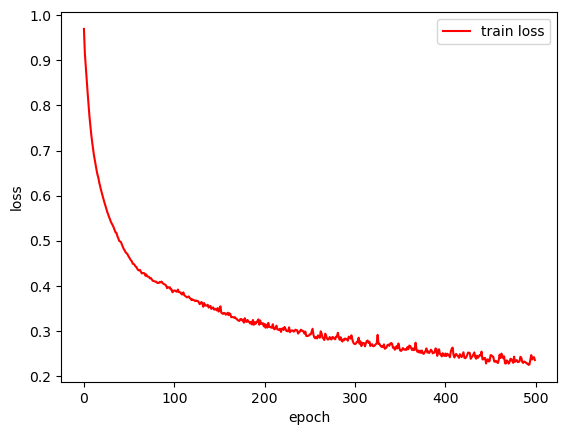

In [14]:

plt.plot(train_loss_list, label='train loss',color='red')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

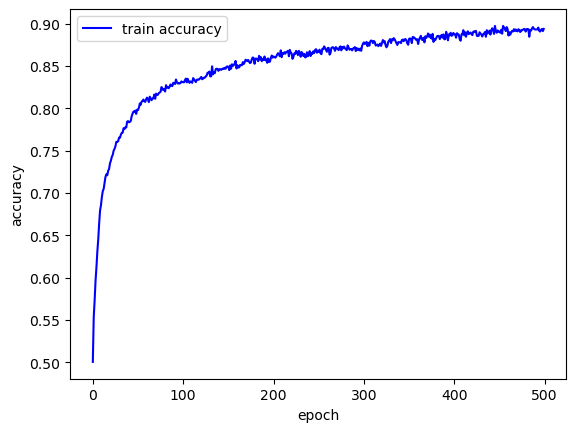

In [15]:
plt.plot(train_acc_list, label='train accuracy',color='blue')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

## Confusion matrix

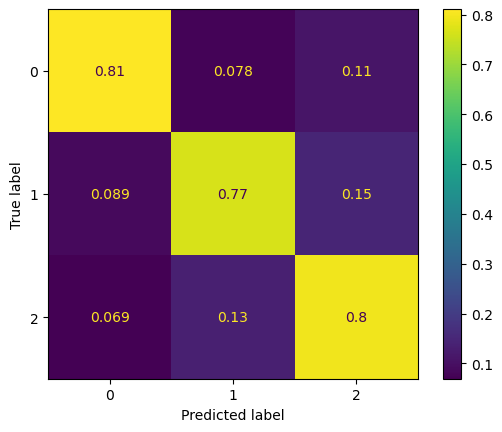

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

confusion_matrix(y_test, listarray)

cm = confusion_matrix(y_test, listarray, labels=[0,1,2],normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1,2])
disp.plot()
plt.show()

In [17]:
from sklearn.metrics import f1_score ## F1 Score 구하기
from sklearn.metrics import accuracy_score
f1 = f1_score(y_test,listarray,pos_label='positive', average='micro')
accuracy_score=accuracy_score(y_test, listarray) * 100
print(f1)
print("정확도: {}".format(accuracy_score))

0.7906675307841866
정확도: 79.06675307841866


C:\Users\Lab01\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1370: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


In [18]:

print('SMOTE 적용 후 테스트용 피처/레이블 데이터 세트: ', X_test.shape, y_test.shape)
# print('SMOTE 적용 전 레이블 값 분포: \n', pd.Series(y).value_counts())
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_test).value_counts())

SMOTE 적용 후 테스트용 피처/레이블 데이터 세트:  torch.Size([1543, 6]) torch.Size([1543])
SMOTE 적용 후 레이블 값 분포: 
 2    550
1    517
0    476
dtype: int64


### AUC

In [19]:
from sklearn import preprocessing
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = preprocessing.LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

In [20]:
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve, auc, roc_auc_score

from sklearn.naive_bayes import GaussianNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# make sample data
n_classes = 3


print("roc_auc_score: ", multiclass_roc_auc_score(y_test, listarray))

roc_auc_score:  0.8429051006484333
